# Use Case 4: How Do Mutations Affect Protein Abundance

## Step 1: Import Packages 

We start the notebook by importing the standard packages for data science. These are useful for playing data in dataframes and for plotting the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Our cancer data and a variety of accessory functions are provided in the cptac package.

In [2]:
import cptac
cptac.download("endometrial")
en = cptac.Endometrial()

## Step 2: Get Data and Find Your Gene of Interest

To begin, we first have to grab the data. We retrieve somatic gene mutations using the `en.get_somatic_mutation()` function. This function returns a pandas dataframe containing the data.

In [3]:
somatic_mutations = en.get_somatic_mutation()

Next, we pick a gene of interest to see how mutation affects the protein abundance. For this example, we will look at the gene that has the highest number of mutations within our cohort, which turns out to be PTEN. If you already knew the name of the gene you wanted, you could just set it directly with `gene="PTEN"`.

In [4]:
gene = somatic_mutations["Gene"].value_counts().index[0]
print(gene)

PTEN


## Step 3: Joining dataframes

The data we're interested in for PTEN currently exists in two different dataframes, one for proteomics and one for the mutations. To make things easy for you, we have created a variety of functions to join data across the dataframes. Here we want to join mutation data with molecular proteomics measurements. To do this, we use the `en.join_omics_to_mutations` function. You need to specify as parameters the molecular dataframe name (here "proteomics") and the gene names to take from the mutation data, as well as those to take from the omics data. This creates a dataframe with several columns, one for the proteomics data, one for the mutation type, one for the mutation location, and one for the sample status. (Note that we also pass an empty list for the `mutations_filter` parameters, which will cause the function to filter multiple mutations down to just one, using a default hierarchy that prefers truncations over missense mutations.) The specified genes are appended onto the column name. This example is for a <i>cis</i> comparison. We could also have specified different genes between the proteomics and mutation data for a <i>trans</i> comparison.

NOTE: The mutation status data comes from a [MAF file](http://www.bx.psu.edu/~dcking/man/maf.xhtml). It is important to understand that this only describes mutated sequences, and therefore is silent about wildtype alleles. Therefore "Wildtype" as returned by this function, is an imputed value when either of two conditions is met: First, for tumors that do not have mutations listed in the MAF file; and second, all non-tumor samples. 

In [5]:
omics_mutations = en.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes=gene, 
                                             omics_genes=gene, mutations_filter=[])
omics_mutations.head()

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 2)


Name,PTEN_proteomics,PTEN_Mutation,PTEN_Location,PTEN_Mutation_Status,Sample_Status
Patient_ID,,,,,
C3L-00006,-0.526,Nonsense_Mutation,p.R233*,Multiple_mutation,Tumor
C3L-00008,-0.830,Missense_Mutation,p.G127R,Single_mutation,Tumor
C3L-00032,-0.941,Nonsense_Mutation,p.W111*,Single_mutation,Tumor
C3L-00090,0.730,Missense_Mutation,p.R130G,Single_mutation,Tumor
C3L-00098,-0.379,Wildtype_Tumor,No_mutation,Wildtype_Tumor,Tumor


## Step 4: Plot data

Our goal with this use case is to visually inspect how the protein abundance changes for patients with a mutation compared to the normal (or wildtype) gene sequence. We are going to use the Seaborn graphics and plotting package, which makes creating figures pretty easy. 

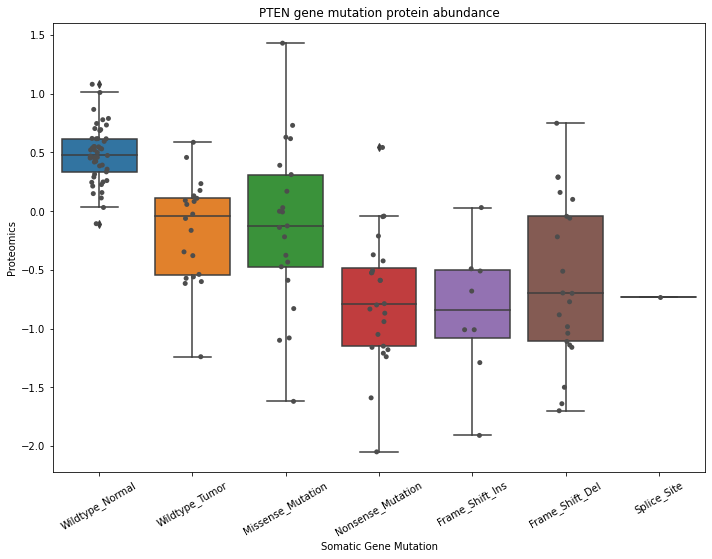

In [6]:
a4_dims = (11.7, 8.27) #dimensions for bigger plot
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=omics_mutations, x=gene + "_Mutation",y=gene +"_proteomics", ax = ax, 
                              order=["Wildtype_Normal","Wildtype_Tumor","Missense_Mutation","Nonsense_Mutation",
                                       "Frame_Shift_Ins","Frame_Shift_Del","Splice_Site"]) 
                                        # order parameter is used to reorder the mutation categories 
somatic_boxplot.set_title("PTEN gene mutation protein abundance")
somatic_boxplot = sns.stripplot(data=omics_mutations, x=gene + "_Mutation",y=gene +"_proteomics",jitter=True, 
                                color=".3", order=["Wildtype_Normal","Wildtype_Tumor","Missense_Mutation",
                                                     "Nonsense_Mutation","Frame_Shift_Ins","Frame_Shift_Del",
                                                     "Splice_Site"])
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
somatic_boxplot.set_xticklabels(somatic_boxplot.get_xticklabels(),rotation=30) # Rotate labels to avoid overlap
plt.show()

## Step 5: Try it again

Let's try this again with a different gene. Beta-catenin (CTNNB1) is also frequently mutated in our cohort and well known as a oncogene. In the following two cells we will again make a joined dataframe (omics_mutations2) and then plot it out.

In [7]:
gene2 = 'CTNNB1'
omics_mutations2 = en.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes=gene2, 
                                              omics_genes=gene2, mutations_filter=[])

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 115 samples for the CTNNB1 gene (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 3)


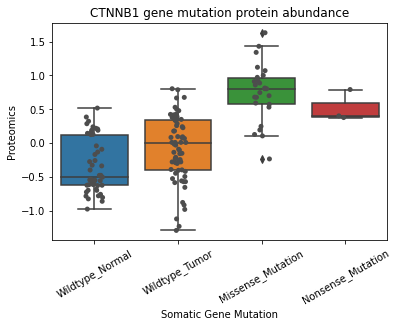

In [8]:
boxplot2 = sns.boxplot(data=omics_mutations2, x=gene2 + "_Mutation",y=gene2 + "_proteomics", 
                       order=["Wildtype_Normal","Wildtype_Tumor","Missense_Mutation","In_Frame_Del"])
boxplot2.set_title("CTNNB1 gene mutation protein abundance")
boxplot2 = sns.stripplot(data=omics_mutations2, x=gene2 + "_Mutation",y=gene2 + "_proteomics",jitter=True, 
                         color=".3", order=["Wildtype_Normal","Wildtype_Tumor","Missense_Mutation","In_Frame_Del"])
boxplot2.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
boxplot2.set_xticklabels(somatic_boxplot.get_xticklabels(),rotation=30)
plt.show()

## Step 6: Repeat with Ovarian data

Let's go through the same process, this time using the Ovarian dataset. Note that function calls are consistent between cancer types.

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 26 samples for the TP53 gene (C:\Users\humbe\miniconda3\lib\site-packages\ipykernel_launcher.py, line 8)


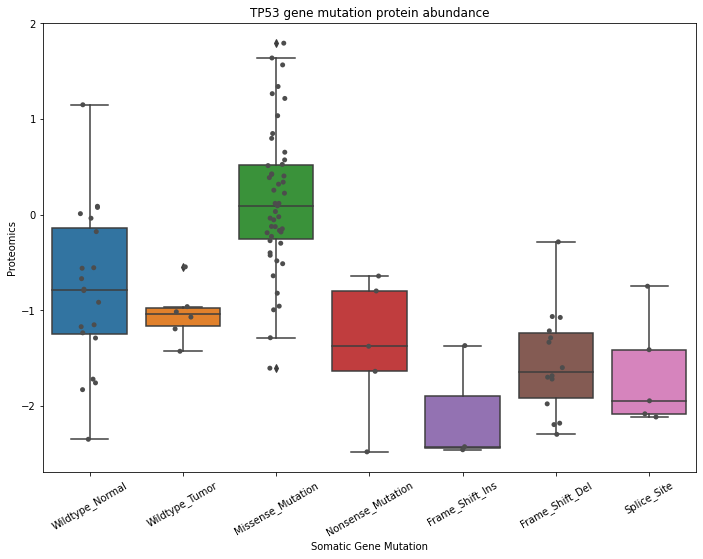

In [9]:
cptac.download("ovarian")
ov = cptac.Ovarian()

somatic_mutations = ov.get_somatic_mutation()

gene = "TP53"
ovarian_omics_mutations = ov.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes=gene, 
                                                     omics_genes=gene, mutations_filter=[])
ovarian_omics_mutations = ov.reduce_multiindex(df=ovarian_omics_mutations, levels_to_drop="Database_ID")

plt.figure(figsize=(11.7, 8.27))

boxplot = sns.boxplot(data=ovarian_omics_mutations, x=gene + "_Mutation", y=gene + "_proteomics", 
                      order=["Wildtype_Normal","Wildtype_Tumor","Missense_Mutation","Nonsense_Mutation",
                             "Frame_Shift_Ins","Frame_Shift_Del","Splice_Site"])
boxplot.set_title("TP53 gene mutation protein abundance")
boxplot = sns.stripplot(data=ovarian_omics_mutations, x=gene + "_Mutation", y=gene + "_proteomics",jitter=True, 
                        color=".3",order=["Wildtype_Normal","Wildtype_Tumor","Missense_Mutation",
                                            "Nonsense_Mutation","Frame_Shift_Ins","Frame_Shift_Del","Splice_Site"])
boxplot.set(xlabel="Somatic Gene Mutation", ylabel="Proteomics")
boxplot.set_xticklabels(somatic_boxplot.get_xticklabels(),rotation=30)
plt.show()